# Example: Path planning problem


This example was borrowed from [1, IX. Examples, A] whose dynamics comes from the model given in [2, Ch. 2.4].
This is a **reachability problem** for a **continuous system**.

Let us consider the 3-dimensional state space control system of the form
$$
\dot{x} = f(x, u)
$$
with $f: \mathbb{R}^3 × U ↦ \mathbb{R}^3$ given by
$$
f(x,(u_1,u_2)) = \begin{bmatrix} u_1 \cos(α+x_3)\cos(α^{-1}) \\ u_1 \sin(α+x_3)\cos(α^{-1}) \\ u_1 \tan(u_2)  \end{bmatrix}
$$
and with $U = [−1, 1] \times [−1, 1]$ and $α = \arctan(\tan(u_2)/2)$. Here, $(x_1, x_2)$ is the position and $x_3$ is the
orientation of the vehicle in the 2-dimensional plane. The control inputs $u_1$ and $u_2$ are the rear
wheel velocity and the steering angle.
The control objective is to drive the vehicle which is situated in a maze made of obstacles from an initial position to a target position.


In order to study the concrete system and its symbolic abstraction in a unified framework, we will solve the problem
for the sampled system with a sampling time $\tau$.

The abstraction is based on a feedback refinment relation [1,V.2 Definition].
Basically, this is equivalent to an alternating simulation relationship with the additional constraint that the input of the
concrete and symbolic system preserving the relation must be identical.
This allows to easily determine the controller of the concrete system from the abstraction controller by simply adding a quantization step.

For the construction of the relations in the abstraction, it is necessary to over-approximate attainable sets of
a particular cell. In this example, we consider the used of a growth bound function  [1, VIII.2, VIII.5] which is one of the possible methods to over-approximate
attainable sets of a particular cell based on the state reach by its center. Therefore, it is used
to compute the relations in the abstraction based on the feedback refinement relation.

For this reachability problem, the abstraction controller is built by solving a fixed-point equation which consists in computing the the pre-image
of the target set.

First, let us import [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) and [Plots].

In [1]:
using StaticArrays, Plots

At this point, we import Dionysos.

In [2]:
using Dionysos
const DI = Dionysos
const DO = DI.Domain
const CO = DI.Control
const UT = DI.Utils
const OP = DI.Optim
const AB = OP.Abstraction

Dionysos.Optim.Abstraction

And the file defining the hybrid system for this problem

In [3]:
include(joinpath(dirname(dirname(pathof(Dionysos))), "problems", "PathPlanning.jl"))

Main.var"##369".PathPlanning

### Definition of the problem

Now we instantiate the problem using the function provided by [PathPlanning.jl](https://github.com/dionysos-dev/Dionysos.jl/blob/master/problems/PathPlanning.jl)

In [4]:
problem = PathPlanning.problem(simple=true, approx_mode="growth");

`F_sys` is the function, `_X_` the state domain and `_U_` the input domain

In [5]:
F_sys = problem.system.f;
_X_ = problem.system.X;
_U_ = problem.system.U;

### Definition of the abstraction

Definition of the grid of the state-space on which the abstraction is based (origin `x0` and state-space discretization `h`):

In [6]:
x0 = SVector(0.0, 0.0, 0.0);
h = SVector(0.2, 0.2, 0.2);
state_grid = DO.GridFree(x0, h);

Definition of the grid of the input-space on which the abstraction is based (origin `u0` and input-space discretization `h`):

In [7]:
u0 = SVector(0.0, 0.0);
h = SVector(0.3, 0.3);
input_grid = DO.GridFree(u0, h);

We now solve the optimal control problem with the `Abstraction.SCOTS.Optimizer`.

In [8]:
using JuMP
optimizer = MOI.instantiate(AB.SCOTS.Optimizer)
MOI.set(optimizer, MOI.RawOptimizerAttribute("problem"), problem)
MOI.set(optimizer, MOI.RawOptimizerAttribute("state_grid"), state_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("input_grid"), input_grid)
MOI.optimize!(optimizer)

abstract_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_controller"))
controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("controller"))

compute_symmodel_from_controlsystem! started
compute_symmodel_from_controlsystem! terminated with success: 9705631 transitions created
 10.293529 seconds (80.38 M allocations: 3.588 GiB, 9.98% gc time, 1.97% compilation time)
compute_controller_reach! started

compute_controller_reach! terminated with success
 13.376158 seconds (82.76 M allocations: 2.701 GiB, 6.17% gc time, 1.22% compilation time)


(::Dionysos.Optim.Abstraction.SCOTS.var"#controller#10"{Dionysos.Optim.Abstraction.SCOTS.var"#controller#9#11"{Dionysos.Optim.Abstraction.SCOTS.Optimizer{Float64}, Dionysos.Symbolic.SymbolicModelList{3, 2, Dionysos.Domain.DomainList{3, Float64, Dionysos.Domain.GridFree{3, Float64}}, Dionysos.Domain.DomainList{2, Float64, Dionysos.Domain.GridFree{2, Float64}}, Dionysos.Symbolic.AutomatonList{Dionysos.Utils.SortedTupleSet{3, Tuple{Int64, Int64, Int64}}}}}}) (generic function with 1 method)

### Trajectory display
We choose a stopping criterion `reached` and the maximal number of steps `nsteps` for the sampled system, i.e. the total elapsed time: `nstep`*`tstep`
as well as the true initial state `x0` which is contained in the initial state-space `_I_` defined previously.

In [9]:
nstep = 100
function reached(x)
    if x∈problem.target_set
        return true
    else
        return false
    end
end
x0 = SVector(0.4, 0.4, 0.0)
x_traj, u_traj = CO.get_closed_loop_trajectory(problem.system.f, controller, x0, nstep; stopping=reached)

(StaticArraysCore.SVector{3, Float64}[[0.4, 0.4, 0.0], [0.5656526976622253, 0.5327713733310602, 0.22682847915906104], [0.25239268897413175, 0.5850280145020785, 0.5670711978976526], [0.3375198974721058, 0.8909952479815533, 0.9073139166362441], [0.3156609448915271, 1.2078308138226075, 1.2475566353748355], [0.18932201723291275, 1.4992086869492613, 1.587799354113427], [0.23773934403141977, 1.7680140287200627, 1.5042785667188283], [0.30841263717793976, 2.0318432062851244, 1.4207577793242296], [0.23188166138766814, 2.3063278590568737, 1.605474717576487], [0.27554044042438713, 2.575946961332387, 1.5219539301818883]  …  [3.3204265002464157, 3.1093301474923565, -1.486401104058723], [3.226055205148615, 2.840456806448283, -1.6711180423109804], [3.2519339678368615, 2.5685545465449193, -1.5875972549163817], [3.3004056189899513, 2.2997589953664743, -1.504076467521783], [3.2654067631375776, 2.0288796322029885, -1.5875972549163817], [3.3138784142906674, 1.7600840810245437, -1.504076467521783], [3.2788

Here we display the coordinate projection on the two first components of the state space along the trajectory.

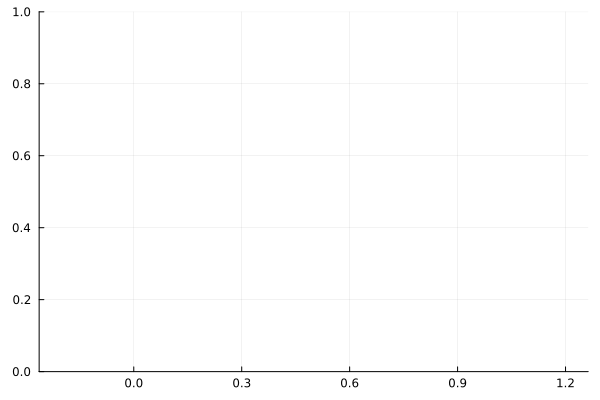

In [10]:
fig = plot(aspect_ratio=:equal)

We display the concrete domain

In [11]:
plot!(problem.system.X, color=:yellow, opacity=0.5)

We display the abstract domain

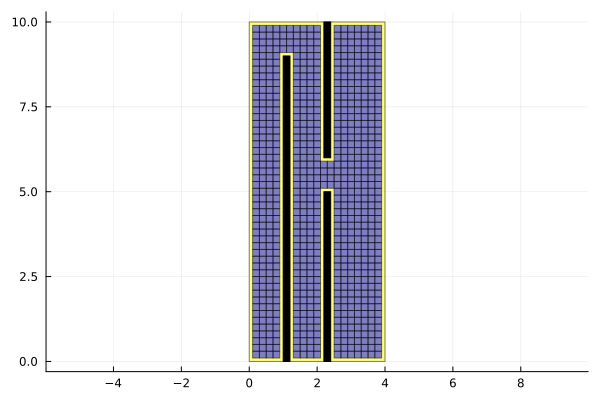

In [12]:
abstract_system = AB.SCOTS.get_abstract_system(optimizer)
plot!(abstract_system.Xdom, color=:blue, opacity=0.5)

We display the concrete specifications

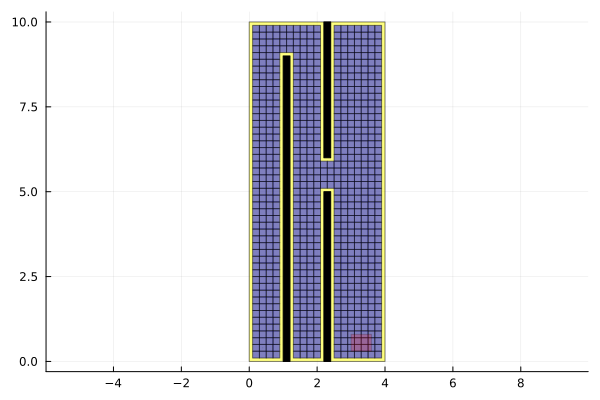

In [13]:
plot!(problem.initial_set, color=:green, opacity=0.2)
plot!(problem.target_set; dims=[1,2], color=:red, opacity=0.2)

We display the abstract specifications

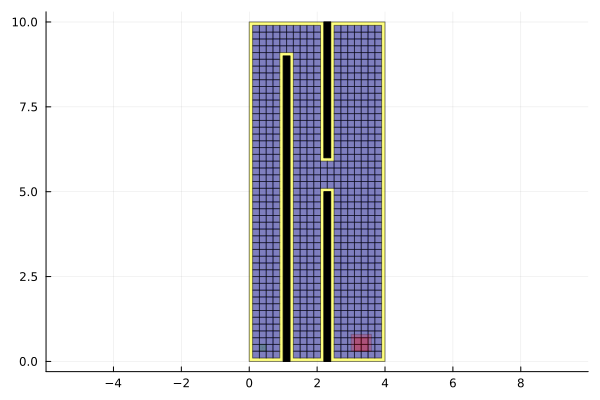

In [14]:
abstract_problem = AB.SCOTS.get_abstract_problem(optimizer)
plot!(abstract_problem.initial_set, color=:green)
plot!(abstract_problem.target_set, color=:red)

We display the concrete trajectory

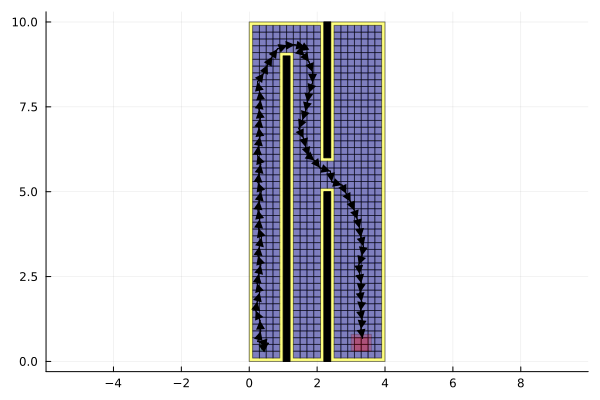

In [15]:
plot!(fig, UT.DrawTrajectory(x_traj), ms=0.5)

display(fig)

### References
1. G. Reissig, A. Weber and M. Rungger, "Feedback Refinement Relations for the Synthesis of Symbolic Controllers," in IEEE Transactions on Automatic Control, vol. 62, no. 4, pp. 1781-1796.
2. K. J. Aström and R. M. Murray, Feedback systems. Princeton University Press, Princeton, NJ, 2008.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*